### data move

### data prep

In [1]:
PATH = '../../../data/cifar/'
TRN_PATH = f'{PATH}train/'
TST_PATH = f'{PATH}test/'

In [2]:
from fastai.conv_learner import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
classes = os.listdir(TRN_PATH)
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [4]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats,sz,aug_tfms=[RandomFlip()],pad=sz//8)
    return ImageClassifierData.from_paths(PATH,val_name='test',tfms=tfms,bs=bs)

In [5]:
bs=256

In [6]:
data = get_data(32,bs)

In [7]:
lr = 1e-2

### data review

In [ ]:
data = get_data(32,4)

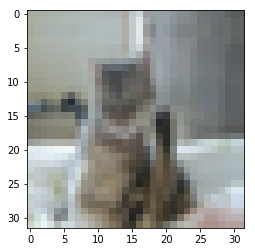

In [9]:
x,y=next(iter(data.trn_dl))
plt.imshow(data.trn_ds.denorm(x)[0]);

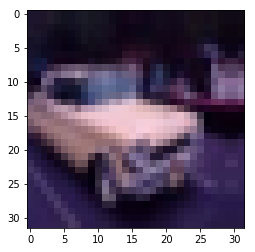

In [10]:
plt.imshow(data.trn_ds.denorm(x)[1]);

## FULLY CONNECTED - SimpleNet

In [13]:
class SimpleNet(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(layers[i],layers[i+1]) for i in range(len(layers)-1)])
        
    def forward(self,x):
        x=x.view(x.size(0),-1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x,dim=-1)

In [14]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3,40,10]),data)

In [15]:
learn

SimpleNet(
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=10, bias=True)
  )
)

In [16]:
[o.numel() for o in learn.model.parameters()]

[122880, 40, 400, 10]

In [17]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [18]:
learn.lr_find()

 77%|███████▋  | 150/196 [00:21<00:08,  5.54it/s, loss=6.7] 

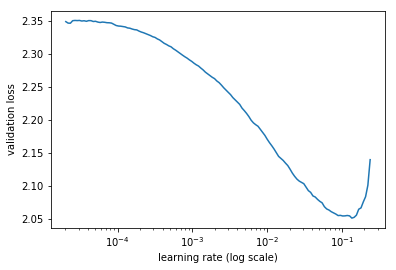

In [19]:
learn.sched.plot()

In [20]:
%time learn.fit(lr,2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.760263   1.634133   0.4162    
    1      1.664661   1.579769   0.4399                     
CPU times: user 1min 55s, sys: 3min 16s, total: 5min 12s
Wall time: 59.3 s


[array([1.57977]), 0.4399]

In [ ]:
%time learn.fit(lr,2,cycle_len=1)

## FULLLY CONVOLUTIONAL - ConvNet

In [6]:
class ConvNet(nn.Module):
    def __init__(self,layers,c):
        super().__init__()
        self.layers = nn.ModuleList(
            [nn.Conv2d(layers[i],layers[i+1],kernel_size=3,stride=2) for i in range(len(layers)-1)])
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.out = nn.Linear(layers[-1],c)
        
    def forward(self,x):
        for l in self.layers:
            x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0),-1)
        return F.log_softmax(self.out(x),dim=-1)

In [10]:
learn = ConvLearner.from_model_data(ConvNet([3,20,40,80],10),data)

In [11]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveAvgPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [13]:
learn.lr_find(end_lr=100)

 73%|███████▎  | 144/196 [00:19<00:11,  4.69it/s, loss=2.5] 

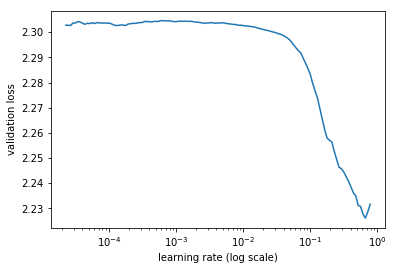

In [14]:
learn.sched.plot()

In [15]:
lr = 1e-1

In [16]:
%time learn.fit(lr,2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.737637   1.609965   0.4007    
    1      1.48996    1.40522    0.4898                     
CPU times: user 2min, sys: 3min 24s, total: 5min 25s
Wall time: 1min 2s


[array([1.40522]), 0.4898]

In [17]:
%time learn.fit(lr,2,cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.356506   1.288466   0.5379    
    1      1.282885   1.216494   0.5661                     
CPU times: user 2min, sys: 3min 30s, total: 5min 30s
Wall time: 1min 2s


[array([1.21649]), 0.5661]

## ## FULLY CONVOLUTIONAL - ConvNet2 (refactored)

In [18]:
class ConvLayer(nn.Module):
    def __init__(self,ni,nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self,x):
        return F.relu(self.conv(x))

In [23]:
class ConvNet2(nn.Module):
    def __init__(self,layers,c):
        super().__init__()
        self.layers = nn.ModuleList(
            [ConvLayer(layers[i],layers[i+1]) for i in range(len(layers)-1)])
        self.out = nn.Linear(layers[-1],c)
        
    def forward(self,x):
        for l in self.layers:
            x = l(x)
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0),-1)
        return F.log_softmax(self.out(x),dim=-1)

In [24]:
learn = ConvLearner.from_model_data(ConvNet2([3,20,40,80],10),data)

In [28]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [26]:
learn.fit(lr,2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.705613   1.541243   0.4415    
    1      1.52793    1.445174   0.4804                     


[array([1.44517]), 0.4804]

In [27]:
%time learn.fit(lr,2,cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.30652    1.239212   0.5568    
    1      1.255956   1.183779   0.5773                     
CPU times: user 1min 57s, sys: 3min 27s, total: 5min 25s
Wall time: 1min 2s


[array([1.18378]), 0.5773]

## BatchNorm

In [8]:
class BnLayer(nn.Module):
    def __init__(self,ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self,x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1),-1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds = x_chan.std(1)[:,None,None]
        return (x-self.means)/self.stds *self.m + self.a

In [15]:
class ConvBnNet(nn.Module):
    def __init__(self,layers,c):
        super().__init__()
        self.conv1 = nn.Conv2d(3,10,kernel_size=5,stride=1,padding=2)
        self.layers = nn.ModuleList(
            [BnLayer(layers[i],layers[i+1]) for i in range(len(layers)-1)])
        self.out = nn.Linear(layers[-1],c)
        
    def forward(self,x):
        x=self.conv1(x)
        for l in self.layers:
            x = l(x)
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0),-1)
        return F.log_softmax(self.out(x),dim=-1)

In [16]:
learn = ConvLearner.from_model_data(ConvBnNet([10,20,40,80,100],10),data)

In [25]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [18]:
learn.lr_find()

 91%|█████████ | 178/196 [00:26<00:03,  5.97it/s, loss=3.87]

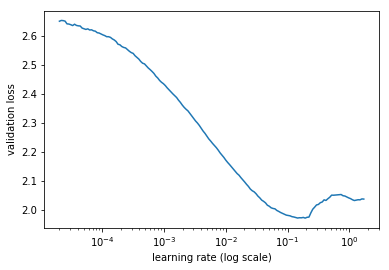

In [19]:
learn.sched.plot()

In [20]:
lr=1e-2

In [23]:
%time learn.fit(lr,2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.500301   1.359298   0.5099    
    1      1.28675    1.217255   0.5662                     
CPU times: user 2min 22s, sys: 4min 12s, total: 6min 35s
Wall time: 1min 6s


[array([1.21726]), 0.5662]

In [24]:
%time learn.fit(lr,4,cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.139604   1.061155   0.6232    
    1      1.089376   1.021034   0.6349                     
    2      1.036059   0.975748   0.6581                     
    3      0.99825    0.929338   0.6698                      
CPU times: user 4min 39s, sys: 8min 26s, total: 13min 6s
Wall time: 2min 11s


[array([0.92934]), 0.6698]

## Deep BatchNorm

In [9]:
class ConvBnNet2(nn.Module):
    def __init__(self,layers,c):
        super().__init__()
        self.conv1 = nn.Conv2d(3,10,kernel_size=5,stride=1,padding=2)
        self.layers = nn.ModuleList(
            [BnLayer(layers[i],layers[i+1]) 
             for i in range(len(layers)-1)])
        self.layers2 = nn.ModuleList(
            [BnLayer(layers[i+1],layers[i+1],1) 
             for i in range(len(layers)-1)])
        self.out = nn.Linear(layers[-1],c)
        
    def forward(self,x):
        x=self.conv1(x)
        for l,l2 in zip(self.layers,self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0),-1)
        return F.log_softmax(self.out(x),dim=-1)

In [14]:
learn = ConvLearner.from_model_data(ConvBnNet2([10,20,40,80,160],10),data)

In [15]:
learn.lr_find()

 84%|████████▎ | 164/196 [00:27<00:06,  4.68it/s, loss=2.34]

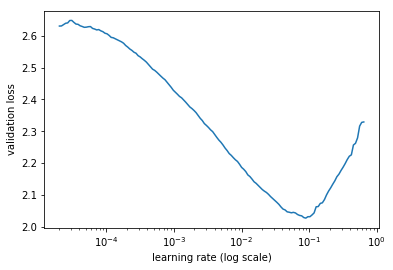

In [16]:
learn.sched.plot()

In [17]:
%time learn.fit(lr,2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.520647   1.429897   0.4774    
    1      1.313325   1.24814    0.5472                     
CPU times: user 2min 38s, sys: 4min 53s, total: 7min 32s
Wall time: 1min 9s


[array([1.24814]), 0.5472]

In [18]:
%time learn.fit(lr,4,cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.103225   1.024609   0.6351    
    1      1.030069   0.953915   0.6579                     
    2      0.963536   0.907213   0.6769                      
    3      0.907328   0.883441   0.6876                      
CPU times: user 5min 22s, sys: 9min 56s, total: 15min 18s
Wall time: 2min 22s


[array([0.88344]), 0.6876]

In [19]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('BnLayer-5',
              OrderedDict

## ResNet

In [9]:
class ResnetLayer(BnLayer):
    def forward(self,x): return x + super().forward(x)

In [10]:
class Resnet(nn.Module):
    def __init__(self,layers,c):
        super().__init__()
        self.conv1 = nn.Conv2d(3,10,kernel_size=5,stride=1,padding=2)
        self.layers = nn.ModuleList(
            [BnLayer(layers[i],layers[i+1]) 
             for i in range(len(layers)-1)])
        self.layers2 = nn.ModuleList(
            [ResnetLayer(layers[i+1],layers[i+1],1) 
             for i in range(len(layers)-1)])
        self.layers3 = nn.ModuleList(
            [ResnetLayer(layers[i+1],layers[i+1],1) 
             for i in range(len(layers)-1)])
        self.out = nn.Linear(layers[-1],c)
        
    def forward(self,x):
        x=self.conv1(x)
        for l,l2,l3 in zip(self.layers,self.layers2,self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0),-1)
        return F.log_softmax(self.out(x),dim=-1)

In [11]:
learn = ConvLearner.from_model_data(Resnet([10,20,40,80,160],10),data)

In [12]:
%time learn.fit(lr,2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.543399   1.420711   0.4956    
    1      1.327712   1.26565    0.5441                     

CPU times: user 2min 56s, sys: 5min 27s, total: 8min 24s
Wall time: 1min 22s


[array([1.26565]), 0.5441]

In [13]:
wd=1e-5

In [14]:
%time learn.fit(lr,4,cycle_len=1,wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.134856   1.09606    0.6099    
    1      1.064022   0.995798   0.6415                     
    2      1.003127   0.942899   0.6636                     
    3      0.959445   0.922964   0.6739                      

CPU times: user 5min 51s, sys: 10min 45s, total: 16min 36s
Wall time: 2min 46s


[array([0.92296]), 0.6739]

In [ ]:
%time learn.fit(lr,8,cycle_len=4,wds=wd)

In [18]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('ResnetLayer-5',
              Ordered

In [19]:
learn

Resnet(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (layers): ModuleList(
    (0): BnLayer(
      (conv): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): BnLayer(
      (conv): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (2): BnLayer(
      (conv): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (3): BnLayer(
      (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
  )
  (layers2): ModuleList(
    (0): ResnetLayer(
      (conv): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): ResnetLayer(
      (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): ResnetLayer(
      (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (3): ResnetLayer(
      (conv): Co

## ResNet extension

In [24]:
class Resnet(nn.Module):
    def __init__(self,layers,c,p=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=5,stride=1,padding=2)
        self.layers = nn.ModuleList(
            [BnLayer(layers[i],layers[i+1]) 
             for i in range(len(layers)-1)])
        self.layers2 = nn.ModuleList(
            [ResnetLayer(layers[i+1],layers[i+1],1) 
             for i in range(len(layers)-1)])
        self.layers3 = nn.ModuleList(
            [ResnetLayer(layers[i+1],layers[i+1],1) 
             for i in range(len(layers)-1)])
        self.drop = nn.Dropout(p)
        self.out = nn.Linear(layers[-1],c)
        
    def forward(self,x):
        x=self.conv1(x)
        for l,l2,l3 in zip(self.layers,self.layers2,self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0),-1)
        x = self.drop(x)
        return F.log_softmax(self.out(x),dim=-1)

In [25]:
learn = ConvLearner.from_model_data(Resnet([16,32,64,128,256],10,0.2),data)

In [26]:
wd=1e-6

In [27]:
%time learn.fit(lr,2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.724367   1.493216   0.4607    
    1      1.407817   1.291177   0.5552                     
CPU times: user 3min 8s, sys: 6min, total: 9min 8s
Wall time: 1min 28s


[array([1.29118]), 0.5552]

In [28]:
%time learn.fit(lr,4,cycle_len=1,wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.155223   1.00844    0.6421    
    1      1.049851   0.959444   0.6605                     
    2      0.968259   0.924762   0.6763                      
    3      0.916748   0.94119    0.6727                      
CPU times: user 6min 21s, sys: 11min 59s, total: 18min 20s
Wall time: 3min


[array([0.94119]), 0.6727]

In [29]:
learn.save('tmp3')

In [30]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [32]:
metrics.log_loss(y,preds),accuracy_np(preds,y)

(0.8911817686954422, 0.6895)